### CS637 Project
### FDI Detection



In [ ]:
!pip install scipy h5py numpy pandas torch scikit-learn


In [ ]:
import scipy.io
import h5py
import numpy as np

def load_mat_file(file_path):
    """
    Loads a .mat file using scipy.io.loadmat or h5py based on the file version.

    Parameters:
        file_path (str): Path to the .mat file.

    Returns:
        dict or None: Dictionary containing MATLAB variables if successful, else None.
    """
    try:
        # Attempt to load with scipy.io.loadmat (supports v4-v7.2)
        mat = scipy.io.loadmat(file_path)
        print("Loaded .mat file using scipy.io.loadmat")
    except NotImplementedError:
        # If NotImplementedError, likely a v7.3 file; use h5py
        try:
            with h5py.File(file_path, 'r') as mat_h5:
                # Convert h5py datasets to NumPy arrays
                mat = {key: np.array(mat_h5[key]) for key in mat_h5.keys() if not key.startswith('__')}
            print("Loaded .mat file using h5py")
        except Exception as e:
            print(f"Error loading .mat file with h5py: {e}")
            mat = None
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        mat = None
    except Exception as e:
        print(f"Error loading .mat file with scipy.io.loadmat: {e}")
        mat = None
    return mat


In [ ]:
# Specify the file path
file_path = '/content/attack_vectors.mat'

# Load the .mat file
mat_data = load_mat_file(file_path)

# Check if loading was successful
if mat_data is not None:
    print("MAT file loaded successfully.")
else:
    print("Failed to load the MAT file.")


Loaded .mat file using scipy.io.loadmat
MAT file loaded successfully.


In [ ]:
if mat_data is not None:
    print("Variables in the MAT file:")
    for key in mat_data.keys():
        print(f"- {key}")


Variables in the MAT file:
- __header__
- __version__
- __globals__
- dataset


In [ ]:
# Replace 'dataset' with the actual variable name from your .mat file
variable_name = 'dataset'  # Update this based on your MAT file

if variable_name in mat_data:
    dataset = mat_data[variable_name]
    print(f"Loaded variable '{variable_name}' with shape {dataset.shape}")
else:
    print(f"Variable '{variable_name}' not found in the MAT file.")
    print("Available variables:")
    for key in mat_data.keys():
        print(f"- {key}")


Loaded variable 'dataset' with shape (2, 16, 100)


In [ ]:
# Transpose to (100, 2, 16)
dataset = np.transpose(dataset, (2, 0, 1))
print(f"Transposed dataset shape: {dataset.shape}")  # Expected: (100, 2, 16)


Transposed dataset shape: (100, 2, 16)


In [ ]:
# Initialize lists to store processed data
processed_data = []

# Define dpast and dfuture
dpast = 3
dfuture = 8

for idx, sample in enumerate(dataset):
    # Extract a_u and a_y
    a_u = sample[0, :14]  # Columns 0-13
    a_y = sample[1, :14]  # Columns 0-13

    # Extract size_a and x0
    size_a = int(sample[0, 14])  # Assuming size_a is in the 15th column
    x0 = sample[:, 15]  # 16th column; shape: (2,)

    # # Validate size_a
    # if size_a < (dpast + dfuture) or size_a > 11:
    #     print(f"Skipping sample {idx}: size_a = {size_a}")
    #     continue  # Skip samples that don't meet the criteria

    # # Extract actual attack vectors based on size_a
    # a_u_actual = a_u[:size_a]
    # a_y_actual = a_y[:size_a]

    # Split into dpast and dfuture
    past_a_u = a_u[:dpast]
    past_a_y = a_y[:dpast]

    future_a_u = a_u[dpast:dpast + dfuture]
    future_a_y = a_y[dpast:dpast + dfuture]

    # Concatenate a_u and a_y for each timestep
    past = np.stack((past_a_u, past_a_y), axis=1) # Shape: (dpast * 2,)
    # past = past.reshape(dpast, 2)  # Shape: (dpast, 2)

    future = np.stack((future_a_u, future_a_y), axis=1) # Shape: (dfuture * 2,)
    # future = future.reshape(dfuture, 2)  # Shape: (dfuture, 2)

    # Store the processed sample
    processed_data.append({
        'input': past,      # Shape: (dpast, 2)
        'target': future,   # Shape: (dfuture, 2)
        'x0': x0            # Shape: (2,)
    })

print(f"Total processed data points: {len(processed_data)} out of {dataset.shape[0]}")
processed_data[2]



Total processed data points: 100 out of 100


{'input': array([[ 5.39376539e+02, -2.69388269e+00],
        [ 1.66031569e+02, -8.91529367e+00],
        [-6.20590040e-02, -1.59746807e+01]]),
 'target': array([[ -73.27878179,  -22.67025958],
        [1100.79318712,  -34.50630641],
        [   0.        ,    0.        ],
        [   0.        ,    0.        ],
        [   0.        ,    0.        ],
        [   0.        ,    0.        ],
        [   0.        ,    0.        ],
        [   0.        ,    0.        ]]),
 'x0': array([21.18186706,  6.10275657])}

In [ ]:
# Define your system matrices (replace with actual values from your script)
A = np.array([[1, 0.1],
              [0, 1]])  # Example state transition matrix

B = np.array([[0.005],
              [0.1]])    # Example control input matrix

C = np.array([1, 0])      # Example output matrix

K = np.array([16.0302, 5.6622])   # Controller gain vector

L = np.array([[1.8721],
              [9.6532]])          # Observer gain matrix

# h = 0.1


In [ ]:

# Lists to store inputs, outputs, and intermediate variables
model_inputs = []    # Each element: {'a_u_past': [...], 'a_y_past': [...]}
model_outputs = []   # Each element: {'y_tilda_future': [...], 'ra_future': [...]}
intermediate_vars = []  # Each element: {'data_point_index': int, 'past': [...], 'future': [...]}

for idx, data_point in enumerate(processed_data):
    # Extract inputs and targets
    a_u_past = data_point['input'][:, 0]       # Shape: (dpast,)
    a_y_past = data_point['input'][:, 1]       # Shape: (dpast,)
    a_u_future = data_point['target'][:, 0]    # Shape: (dfuture,)
    a_y_future = data_point['target'][:, 1]    # Shape: (dfuture,)
    x0 = data_point['x0']                      # Shape: (2,)

    # Initialize actual and estimated states
    x_a = x0.copy()       # Actual state
    xhat_a = x0.copy()    # Estimated state

    # Initialize lists to store outputs
    y_a_past = []
    r_a_past = []
    y_tilda_a_future = []
    r_a_future = []

    # Initialize lists to store intermediate variables
    vars_past = []
    vars_future = []

    # -----------------------------
    # Initial Step for dpast Timesteps
    # -----------------------------

    # Handle the first timestep (t=0) outside the loop
    t = 0
    a_u_k = a_u_past[t]
    a_y_k = a_y_past[t]

    # Controller input
    u_a = -K @ xhat_a   # Scalar

    # Attack-controlled input
    uhat_a = u_a + a_u_k    # Scalar

    # Compute y_a(k) based on x_a(k)
    y_a_current = C @ x_a + a_y_k  # Scalar

    # # Update actual state x_a(k+1)
    # x_a_new = A @ x_a + B.flatten() * uhat_a + w_k  # Shape: (2,)

    # # Compute y_a(k+1) based on x_a(k+1)
    # y_a_next = C @ x_a_new + v_k  # Assuming a_y(k+1) is handled separately

    # # Compute yhat_a(k+1)
    # yhat_a_next = C @ (A @ xhat_a + B.flatten() * u_a)  # Scalar

    # # Compute residual r_a(k+1)
    # r_a_next = y_a_next - yhat_a_next  # Scalar

    # Update estimated state xhat_a(k+1)
    # xhat_a_new = A @ xhat_a + B.flatten() * u_a + L.flatten() * r_a_next  # Shape: (2,)

    # # Compute estimation error e_a(k)
    # e_a = x_a - xhat_a  # Shape: (2,)

    # Compute y_tilda for first timestep
    y_tilda = y_a_current - a_y_k  # y_tilda = y_a - a_y

    # Store y_tilda and r_a for the first timestep
    y_a_past.append(y_a_current)
    r_a_past.append(0)

    # Preserve intermediate variables for the first timestep
    vars_past.append({
        'timestep': t+1 ,
        'x_a': x_a.copy(),
        'xhat_a': xhat_a.copy(),
        'u_a': u_a,
        'uhat_a': uhat_a,
        'y_a': y_a_current,
        'yhat_a': y_a_current,
        'r_a': 0 ,
        'y_tilda': y_tilda
    })

    # Update states for next timestep
    # x_a = x_a_new.copy()
    # xhat_a = xhat_a_new.copy()

    # -----------------------------
    # Compute for Remaining dpast Timesteps (t=1 to dpast-1)
    # -----------------------------

    for t in range(1, dpast):
        a_u_k = a_u_past[t]
        a_y_k = a_y_past[t]

        x_a_new = A @ x_a + B.flatten() * uhat_a   # Shape: (2,)

        y_a_current = C @ x_a_new + a_y_k

                # Compute yhat_a(k+1)
        yhat_a_current = C @ (A @ xhat_a + B.flatten() * u_a)  # Scalar

                # Compute residual r_a(k+1)
        r_a = y_a_current - yhat_a_current  # Scalar

        xhat_a_new = A @ xhat_a + B.flatten() * u_a + L.flatten() * r_a


        # Controller input
        u_a = -K @ xhat_a_new   # Scalar

        # Attack-controlled input
        uhat_a = u_a + a_u_k    # Scalar



        # Compute y_tilda for current timestep
        y_tilda = y_a_current - a_y_k  # y_tilda = y_a - a_y

        # Store y_tilda and r_a for current timestep
        y_a_past.append(y_a_current)
        r_a_past.append(r_a)

        # Preserve intermediate variables
        vars_past.append({
            'timestep': t +1,
            'x_a': x_a_new.copy(),
            'xhat_a': xhat_a_new.copy(),
            'u_a': u_a,
            'uhat_a': uhat_a,
            'y_a': y_a_current,
            'yhat_a': yhat_a_current,
            'r_a': r_a,
            'y_tilda': y_tilda
        })

        # Update states for next timestep
        x_a = x_a_new.copy()
        xhat_a = xhat_a_new.copy()

    # -----------------------------
    # Compute for dfuture Timesteps
    # -----------------------------

    for t in range(dfuture):
        a_u_k = a_u_future[t]
        a_y_k = a_y_future[t]

        x_a_new = A @ x_a + B.flatten() * uhat_a   # Shape: (2,)

        y_a_current = C @ x_a_new + a_y_k

                # Compute yhat_a(k+1)
        yhat_a_current = C @ (A @ xhat_a + B.flatten() * u_a)  # Scalar

                # Compute residual r_a(k+1)
        r_a = y_a_current - yhat_a_current  # Scalar

        xhat_a_new = A @ xhat_a + B.flatten() * u_a + L.flatten() * r_a


        # Controller input
        u_a = -K @ xhat_a_new   # Scalar

        # Attack-controlled input
        uhat_a = u_a + a_u_k    # Scalar

                # Compute y_tilda for current timestep
        y_tilda = y_a_current - a_y_k  # y_tilda = y_a - a_y

        # Store y_tilda and r_a for future timestep
        y_tilda_a_future.append(y_tilda)
        r_a_future.append(r_a)

        # Preserve intermediate variables
        vars_future.append({
            'timestep': t + 1,
            'x_a': x_a_new.copy(),
            'xhat_a': xhat_a_new.copy(),
            'u_a': u_a,
            'uhat_a': uhat_a,
            'y_a': y_a_current,
            'yhat_a': yhat_a_current,
            'r_a': r_a,
            'y_tilda': y_tilda,
        })

        # Update states for next timestep
        x_a = x_a_new.copy()
        xhat_a = xhat_a_new.copy()

    # -----------------------------
    # Store Processed Data
    # -----------------------------

    # Append to model inputs and outputs
    model_inputs.append({
        'y_a_past': y_a_past,   # Array of dpast a_u values
        'r_a_past': r_a_past    # Array of dpast a_y values
    })

    model_outputs.append({
        'y_tilda_future': y_tilda_a_future,  # List of dfuture y_tilda values
        'ra_future': r_a_future             # List of dfuture r_a values
    })

    # Append intermediate variables
    intermediate_vars.append({
        'data_point_index': idx,
        'past': vars_past,       # List of dicts for dpast timesteps
        'future': vars_future    # List of dicts for dfuture timesteps
    })

model_inputs[0]


{'y_a_past': [19.77441667750995, 14.646027542037583, 11.879963904679949],
 'r_a_past': [0, -6.021253640476644, 9.82734890166175]}

In [ ]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader  # Ensure Dataset and DataLoader are imported
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
import pickle

In [ ]:

# Convert lists to NumPy arrays
inputs_y_a_past = np.array([item['y_a_past'] for item in model_inputs])       # Shape: (num_samples, dpast)
inputs_r_a_past = np.array([item['r_a_past'] for item in model_inputs])       # Shape: (num_samples, dpast)

outputs_y_tilda_future = np.array([item['y_tilda_future'] for item in model_outputs])  # Shape: (num_samples, dfuture)
outputs_ra_future = np.array([item['ra_future'] for item in model_outputs])              # Shape: (num_samples, dfuture)

# Combine a_u_past and a_y_past as separate features
inputs_combined = np.stack((inputs_y_a_past, inputs_r_a_past), axis=2)  # Shape: (num_samples, dpast, 2)

# Combine y_tilda_future and ra_future as output features
outputs_combined = np.stack((outputs_y_tilda_future, outputs_ra_future), axis=2)
 # Shape: (num_samples, dfuture, 2)
inputs_combined[0]

array([[19.77441668,  0.        ],
       [14.64602754, -6.02125364],
       [11.8799639 ,  9.8273489 ]])

In [ ]:
# Split into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    inputs_combined, outputs_combined, test_size=0.2, random_state=42
)

print(f"Training set shape: Inputs {X_train.shape}, Outputs {y_train.shape}")
print(f"Testing set shape: Inputs {X_test.shape}, Outputs {y_test.shape}")

Training set shape: Inputs (80, 3, 2), Outputs (80, 8, 2)
Testing set shape: Inputs (20, 3, 2), Outputs (20, 8, 2)


In [ ]:

class AttackDataset(Dataset):
    def __init__(self, inputs, targets):
        """
        Args:
            inputs (numpy array): Shape (num_samples, dpast, 2)
            targets (numpy array): Shape (num_samples, dfuture, 2)
        """
        self.inputs = torch.tensor(inputs, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.float32)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]


In [ ]:
# Create datasets
train_dataset = AttackDataset(X_train, y_train)
test_dataset = AttackDataset(X_test, y_test)

# Create DataLoaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training samples: {len(train_loader.dataset)}")
print(f"Testing samples: {len(test_loader.dataset)}")

Training samples: 80
Testing samples: 20


In [ ]:

class GRUModel(nn.Module):
    def __init__(self, input_size=2, hidden_size=64, num_layers=2, output_size=2, dfuture=8):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dfuture = dfuture
        self.output_size = output_size

        # GRU layer
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)

        # Fully connected layer
        self.fc = nn.Linear(hidden_size, dfuture * output_size)

    def forward(self, x):
        # Initialize hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)  # (num_layers, batch, hidden_size)

        # Forward propagate GRU
        out, _ = self.gru(x, h0)  # out: (batch, dpast, hidden_size)

        # Take the output from the last timestep
        out = out[:, -1, :]  # (batch, hidden_size)

        # Pass through the fully connected layer
        out = self.fc(out)    # (batch, dfuture * output_size)

        # Reshape to (batch, dfuture, output_size)
        out = out.view(-1, self.dfuture, self.output_size)

        return out


In [ ]:
# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialize the model
model = GRUModel(input_size=2, hidden_size=64, num_layers=2, output_size=2, dfuture=dfuture).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Using device: cpu


In [ ]:
!pip install matplotlib


In [ ]:
class MAPE(nn.Module):
    def __init__(self):
        super(MAPE, self).__init__()

    def forward(self, y_pred, y_true):
        epsilon = 1e-8  # To avoid division by zero
        return torch.mean(torch.abs((y_true - y_pred) / (y_true + epsilon))) * 100

# Initialize MAPE
mape = MAPE().to(device)



In [ ]:
num_epochs = 2500  # Adjust as needed

# Lists to store loss values
train_mape_history = []
val_mape_history = []

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader  # Ensure Dataset and DataLoader are imported
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
import pickle
import matplotlib.pyplot as plt  # Importing matplotlib for plotting

# Assuming the rest of your setup (model, data loaders, etc.) is already done

# Initialize MAPE
mape = MAPE().to(device)

# Lists to store loss values
train_mape_history = []
val_mape_history = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_mape = 0.0
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        error = mape(outputs, targets)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_mape += error.item()

    # Calculate average training loss and MAPE
    avg_train_loss = train_loss / len(train_loader)
    avg_train_mape = train_mape / len(train_loader)
    train_mape_history.append(avg_train_mape)

    # Validation loss and MAPE
    model.eval()
    val_loss = 0.0
    val_mape = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            error = mape(outputs, targets)

            val_loss += loss.item()
            val_mape += error.item()
    avg_val_loss = val_loss / len(test_loader)
    avg_val_mape = val_mape / len(test_loader)
    val_mape_history.append(avg_val_mape)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Training MSE: {avg_train_loss:.4f}, Training MAPE: {avg_train_mape:.2f}%, "
              f"Validation MSE: {avg_val_loss:.4f}, Validation MAPE: {avg_val_mape:.2f}%")


Epoch [1/2500], Training MSE: 4488.2735, Training MAPE: 99.94%, Validation MSE: 3241.7759, Validation MAPE: 99.95%
Epoch [10/2500], Training MSE: 4363.0665, Training MAPE: 92.33%, Validation MSE: 3050.0413, Validation MAPE: 95.63%
Epoch [20/2500], Training MSE: 4225.5103, Training MAPE: 84.55%, Validation MSE: 2834.3279, Validation MAPE: 90.89%
Epoch [30/2500], Training MSE: 4059.7198, Training MAPE: 84.18%, Validation MSE: 2608.2512, Validation MAPE: 86.21%
Epoch [40/2500], Training MSE: 3842.7134, Training MAPE: 85.69%, Validation MSE: 2394.2275, Validation MAPE: 83.52%
Epoch [50/2500], Training MSE: 3643.7924, Training MAPE: 85.85%, Validation MSE: 2217.3757, Validation MAPE: 81.63%
Epoch [60/2500], Training MSE: 3448.3704, Training MAPE: 82.86%, Validation MSE: 2064.3739, Validation MAPE: 79.64%
Epoch [70/2500], Training MSE: 3288.9045, Training MAPE: 80.17%, Validation MSE: 1933.6721, Validation MAPE: 78.01%
Epoch [80/2500], Training MSE: 3151.6668, Training MAPE: 78.63%, Validati

In [ ]:
import matplotlib.pyplot as plt

def plot_mape(train_mape, val_mape, num_epochs, save_path=None):
    """
    Plots Training and Validation MAPE over epochs and optionally saves the plot.

    Args:
        train_mape (list or array): Training MAPE values per epoch.
        val_mape (list or array): Validation MAPE values per epoch.
        num_epochs (int): Total number of epochs.
        save_path (str, optional): Path to save the plot image. If None, the plot is not saved.
    """
    epochs = range(1, num_epochs + 1)
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, train_mape, label='Training MAPE', color='blue', marker='o')
    plt.plot(epochs, val_mape, label='Validation MAPE', color='red', marker='x')
    plt.xlabel('Epoch')
    plt.ylabel('MAPE (%)')
    plt.title('Training and Validation MAPE over Epochs')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300)  # dpi=300 for high-resolution images
        print(f"Plot saved as '{save_path}'")

    plt.show()


Plot saved as 'mape_plot.png'


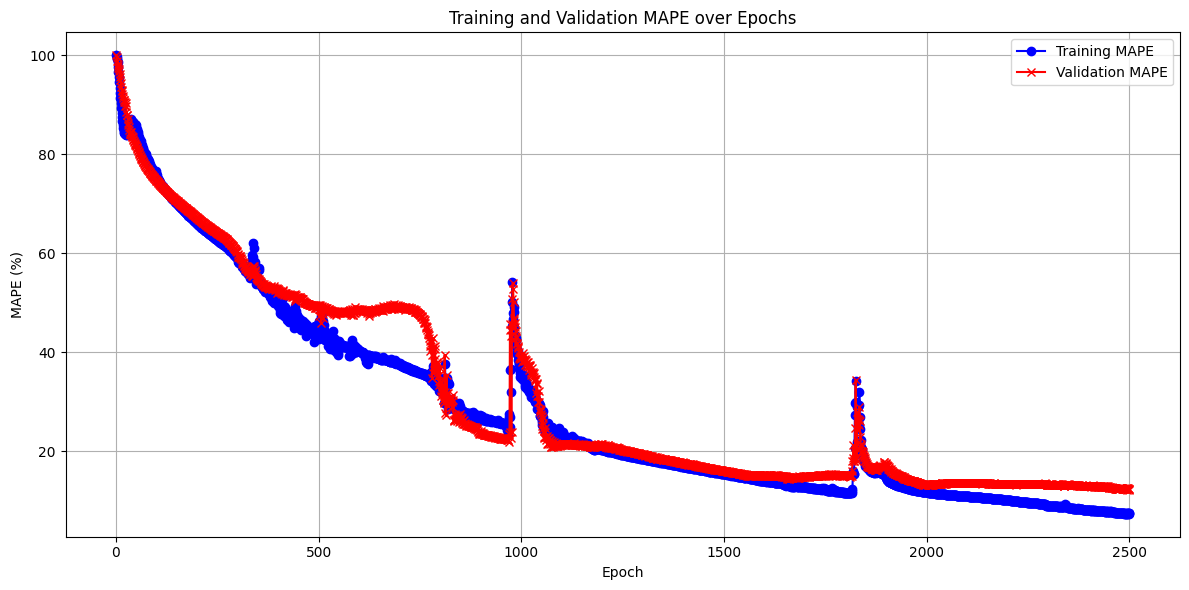

In [ ]:
# After training is complete
# train_mape_history = train_mape_history[1:2480]
# val_mape_history = val_mape_history[1:2480]
plot_mape(train_mape_history, val_mape_history, num_epochs , save_path='mape_plot.png')


In [ ]:
torch.save(model.state_dict(), 'gru_attack_predictor.pth')
print("Model saved as 'gru_attack_predictor.pth'")

Model saved as 'gru_attack_predictor.pth'
